In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_excel('/Users/ahmadazhar/Desktop/Dashboard/data.xlsx')

Data Cleaning

In [3]:
# Drop columns with all same values
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index

df.drop(cols_to_drop, axis=1, inplace=True)

In [4]:
# Drop columns that are null
cols_to_drop = df.columns[df.isnull().any()]

if df[cols_to_drop].value_counts().values.size > 0:
  print(df[cols_to_drop].value_counts())
else:
  df.drop(cols_to_drop, axis=1, inplace=True)

In [5]:
# Drop columns with mostly common values
mostly_same_cols = df.columns

for col in mostly_same_cols:
  common_percentage = df[col].value_counts().max() / df.shape[0] * 100
  if common_percentage > 90:
    print(f"Column '{col}' has {common_percentage:.2f}% of: {df[col].value_counts().idxmax()}")
    df.drop(col, axis=1, inplace=True)

Column 'CreditLimit' has 98.99% of: 0
Column 'PaymentTerms' has 98.99% of: Cash on Delivery
Column 'DueDateCalc' has 98.99% of: 0D
Column 'Discount' has 93.72% of: 0.0
Column 'BaseUOM' has 99.90% of: PC


In [6]:
print("Shape of Data: ", df.shape, " -- ", "Number of Null Values: ", df.isnull().sum().sum())
print("\nColumns: ")
", ".join(df.columns)

Shape of Data:  (988, 25)  --  Number of Null Values:  0

Columns: 


'CustNo, CustName, Address, BarangayName, ProvinceName, SalesManTerritory, InvNo, InvDt, DoDt, DeliveryDate, Salesman, SubTotal, GstAmt, TotalAmt, PaidAmt, DueDate, LineNo, ItemNo, UOM, Qty, Price, SubAmt, ItemName, BaseQty, ts'

In [7]:
column_mapping = { 'CustNo': 'customer_number', 'CustName': 'customer_name', 'Address': 'customer_address', 'BarangayName': 'district', 'ProvinceName': 'province', 'SalesManTerritory': 'salesman_territory', 'InvNo': 'invoice_number', 'InvDt': 'invoice_date', 'DoDt': 'delivery_order_date', 'DeliveryDate': 'delivery_date', 'Salesman': 'salesman_name', 'DueDate': 'due_date', 'UOM': 'unit_of_measurement', 'ItemName': 'product_name', 'SubTotal': 'subtotal_amount', 'GstAmt': 'gst_amount', 'TotalAmt': 'total_amount', 'PaidAmt': 'paid_amount', 'Price': 'product_price', 'SubAmt': 'sub_amount', 'LineNo': 'line_number', 'ItemNo': 'item_number', 'Qty': 'quantity', 'BaseQty': 'base_quantity', 'ts': 'timestamp' }

df.rename(columns=column_mapping, inplace=True)

In [8]:
new_df = df.copy()

# new_df.to_excel('cleaned_data.xlsx', index=False)

Data Preprocessing

In [9]:
pip install category_encoders

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [10]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [11]:
# Make -ve column absolute
numeric_cols = new_df.select_dtypes(include=np.number).columns

for col in numeric_cols:
  if (new_df[col] < 0).any():
    new_df[col] = new_df[col].abs()

In [12]:
# Categorical Columns
new_df['district'] = new_df['district'].astype('category')
new_df['province'] = new_df['province'].astype('category')
new_df['salesman_territory'] = new_df['salesman_territory'].astype('category')
new_df['unit_of_measurement'] = new_df['unit_of_measurement'].astype('category')

In [13]:
# format: 2024-03-06 12:00:00
new_df['invoice_date'] = pd.to_datetime(new_df['invoice_date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
new_df['delivery_order_date'] = pd.to_datetime(new_df['delivery_order_date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
new_df['delivery_date'] = pd.to_datetime(new_df['delivery_date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
new_df['due_date'] = pd.to_datetime(new_df['due_date'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

In [14]:
# Drop columns not useful for model
new_df.drop(['customer_name', 'customer_address', 'timestamp'], axis=1, inplace=True)

In [15]:
new_df.head(2)

,customer_number,district,province,salesman_territory,invoice_number,invoice_date,delivery_order_date,delivery_date,salesman_name,subtotal_amount,...,paid_amount,due_date,line_number,item_number,unit_of_measurement,quantity,product_price,sub_amount,product_name,base_quantity
0,002-19142,Sampaloc,RIZAL,002-PSS06,002-CMQAJ000016465,2023-01-04 12:00:00,2024-08-30 12:44:58,2024-08-30 12:44:58,LEONARD DORINGO,469.95,...,526.34,2023-01-04 12:00:00,2,6250190001,PC,3,28.75,77.0089,555 T. FLKS IN OIL 155g EOE,1
1,002-17827,Pantok,RIZAL,002-PSS09,002-CMQAJ000016486,2023-01-05 12:00:00,2024-08-30 12:44:58,2024-08-30 12:44:58,MARK ESCALA,3627.01,...,4062.25,2023-01-05 12:00:00,1,6250190001,PC,25,28.75,641.7411,555 T. FLKS IN OIL 155g EOE,1


In [16]:
# Min Max Scale
scaler = MinMaxScaler()
columns_to_scale = ['subtotal_amount', 'gst_amount', 'total_amount', 'paid_amount', 'product_price', 'sub_amount', 'base_quantity', 'quantity']

new_df[columns_to_scale] = scaler.fit_transform(new_df[columns_to_scale])

In [17]:
# Label Encode
label_encoder = LabelEncoder()
new_df['customer_number'] = label_encoder.fit_transform(new_df['customer_number'])
new_df['invoice_number'] = label_encoder.fit_transform(new_df['invoice_number'])
new_df['salesman_name'] = label_encoder.fit_transform(new_df['salesman_name'])
new_df['product_name'] = label_encoder.fit_transform(new_df['product_name'])

In [18]:
# Frequency Encoding
encoder = ce.CountEncoder(cols=['district'])
new_df['district'] = encoder.fit_transform(new_df['district'])

In [19]:
# One Hot Encoding
new_df = pd.get_dummies(new_df, columns=['province'], drop_first=True)
new_df = pd.get_dummies(new_df, columns=['salesman_territory'], drop_first=True)
new_df = pd.get_dummies(new_df, columns=['unit_of_measurement'], drop_first=True)

In [20]:
# Feature Extraction on Datetime columns
new_df['invoice_day_of_week'] = new_df['invoice_date'].dt.dayofweek
new_df['invoice_month'] = new_df['invoice_date'].dt.month
new_df['invoice_day_of_month'] = new_df['invoice_date'].dt.day

new_df['delivery_order_day_of_week'] = new_df['delivery_order_date'].dt.dayofweek
new_df['delivery_order_month'] = new_df['delivery_order_date'].dt.month
new_df['delivery_order_day_of_month'] = new_df['delivery_order_date'].dt.day

new_df['delivery_day_of_week'] = new_df['delivery_date'].dt.dayofweek
new_df['delivery_month'] = new_df['delivery_date'].dt.month
new_df['delivery_day_of_month'] = new_df['delivery_date'].dt.day

new_df['due_day_of_week'] = new_df['due_date'].dt.dayofweek
new_df['due_month'] = new_df['due_date'].dt.month
new_df['due_day_of_month'] = new_df['due_date'].dt.day

In [21]:
# Difference between features
new_df['days_until_due'] = (new_df['due_date'] - new_df['invoice_date']).dt.days
new_df['days_until_due'] = new_df['days_until_due'].fillna(0)

new_df['days_until_delivery'] = (new_df['delivery_date'] - new_df['invoice_date']).dt.days
new_df['days_until_delivery'] = new_df['days_until_delivery'].fillna(0)

new_df['days_until_delivery_order'] = (new_df['delivery_order_date'] - new_df['invoice_date']).dt.days
new_df['days_until_delivery_order'] = new_df['days_until_delivery_order'].fillna(0)

new_df.drop(['invoice_date', 'delivery_order_date', 'delivery_date', 'due_date','sub_amount'], axis=1, inplace=True)

Training Model

In [22]:
X = new_df.drop('quantity', axis=1)
y = new_df['quantity']

In [23]:
pip install catboost

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [24]:
# !pip install xgboost
# !pip install lightgbm

# pip install dask[dataframe]


In [25]:
# import xgboost as xgb
# import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [27]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f} -- Root Mean Squared Error: {rmse:.2f} -- R-squared: {r2:.2f}")

Mean Squared Error: 0.03 -- Root Mean Squared Error: 0.17 -- R-squared: 0.64


In [28]:
# Decision Tree
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f} -- Root Mean Squared Error: {rmse:.2f} -- R-squared: {r2:.2f}")

Mean Squared Error: 0.02 -- Root Mean Squared Error: 0.13 -- R-squared: 0.80


In [29]:
feature_importances = pd.Series(decision_tree.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

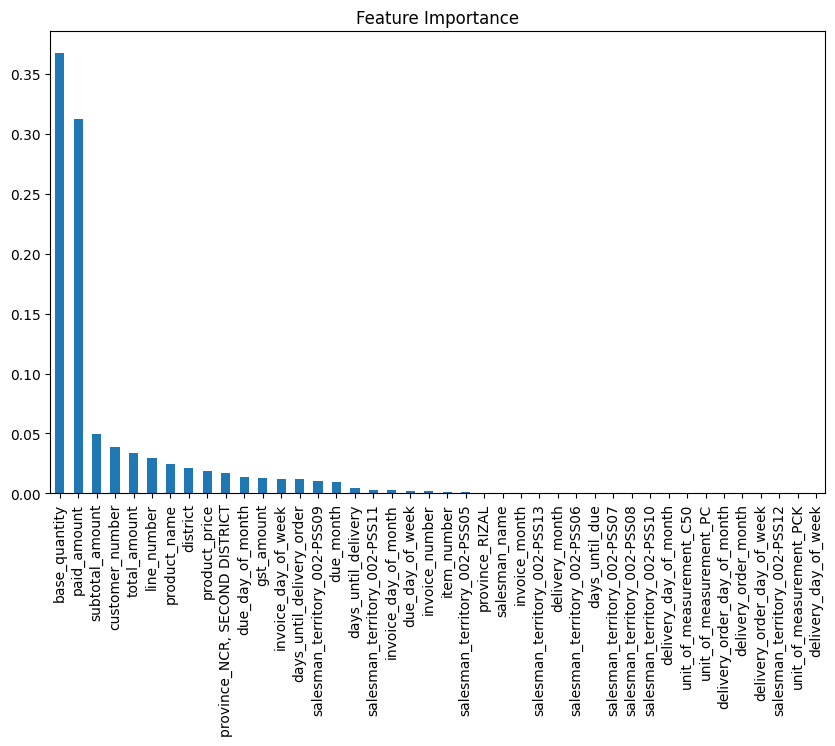

In [30]:
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [31]:
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f} -- Root Mean Squared Error: {rmse:.2f} -- R-squared: {r2:.2f}")

Mean Squared Error: 0.01 -- Root Mean Squared Error: 0.10 -- R-squared: 0.88


In [32]:
X_train.columns

Index(['customer_number', 'district', 'invoice_number', 'salesman_name',
       'subtotal_amount', 'gst_amount', 'total_amount', 'paid_amount',
       'line_number', 'item_number', 'product_price', 'product_name',
       'base_quantity', 'province_NCR, SECOND DISTRICT', 'province_RIZAL',
       'salesman_territory_002-PSS05', 'salesman_territory_002-PSS06',
       'salesman_territory_002-PSS07', 'salesman_territory_002-PSS08',
       'salesman_territory_002-PSS09', 'salesman_territory_002-PSS10',
       'salesman_territory_002-PSS11', 'salesman_territory_002-PSS12',
       'salesman_territory_002-PSS13', 'unit_of_measurement_C50',
       'unit_of_measurement_PC', 'unit_of_measurement_PCK',
       'invoice_day_of_week', 'invoice_month', 'invoice_day_of_month',
       'delivery_order_day_of_week', 'delivery_order_month',
       'delivery_order_day_of_month', 'delivery_day_of_week', 'delivery_month',
       'delivery_day_of_month', 'due_day_of_week', 'due_month',
       'due_day_of_month'

In [33]:
X_train_reduced = X_train[['item_number','customer_number', 'product_price','base_quantity', 'total_amount', 'gst_amount', 'due_day_of_week', 'due_month', 'due_day_of_month']]

# Retrain the model
random_forest_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_reduced.fit(X_train_reduced, y_train)

# Save the new model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(random_forest_reduced, f)

In [34]:
# # XGBoost
# xgb_regressor = xgb.XGBRegressor(n_estimators=10, random_state=2)
# xgb_regressor.fit(X_train, y_train)

# results = xgb_regressor.get_booster().predict(xgb.DMatrix(X_test))
# mse = mean_squared_error(y_test, results)
# rmse = mse**0.5
# r2 = r2_score(y_test, results)

# print(f"Mean Squared Error: {mse:.2f} -- Root Mean Squared Error: {rmse:.2f} -- R-squared: {r2:.2f}")

In [35]:
# pip install google.colab

In [36]:
# catboost
catboost_regressor = cb.CatBoostRegressor(n_estimators=100, random_state=42)
catboost_regressor.fit(X_train, y_train)

predictions = catboost_regressor.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mse**0.5
r2 = r2_score(y_test, predictions)

# from google.colab import output; output.clear()
print(f"Mean Squared Error: {mse:.2f} -- Root Mean Squared Error: {rmse:.2f} -- R-squared: {r2:.2f}")

Learning rate set to 0.251083
0:	learn: 0.2268769	total: 61ms	remaining: 6.04s
1:	learn: 0.1982033	total: 61.9ms	remaining: 3.03s
2:	learn: 0.1764881	total: 62.7ms	remaining: 2.03s
3:	learn: 0.1592296	total: 64.1ms	remaining: 1.54s
4:	learn: 0.1452160	total: 65.2ms	remaining: 1.24s
5:	learn: 0.1350084	total: 66.1ms	remaining: 1.03s
6:	learn: 0.1268255	total: 66.9ms	remaining: 889ms
7:	learn: 0.1221244	total: 67.9ms	remaining: 781ms
8:	learn: 0.1167380	total: 68.8ms	remaining: 696ms
9:	learn: 0.1138723	total: 69.6ms	remaining: 627ms
10:	learn: 0.1109305	total: 70.7ms	remaining: 572ms
11:	learn: 0.1086154	total: 71.6ms	remaining: 525ms
12:	learn: 0.1053636	total: 72.6ms	remaining: 486ms
13:	learn: 0.1024604	total: 73.6ms	remaining: 452ms
14:	learn: 0.1013948	total: 74.5ms	remaining: 422ms
15:	learn: 0.0996134	total: 75.4ms	remaining: 396ms
16:	learn: 0.0976877	total: 76.4ms	remaining: 373ms
17:	learn: 0.0965260	total: 77.2ms	remaining: 352ms
18:	learn: 0.0953881	total: 78.2ms	remaining: 